In [1]:
import netCDF4 as nc
import scipy 
import os
import re
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import dask
from xmhw.xmhw import threshold, detect
from datetime import date
import statsmodels.api as sm
import statsmodels.formula.api as smf
import plotly.express as px
import plotly.graph_objects as go
import hashlib
import matplotlib.colors as mcolors

In [12]:
df_name = pd.DataFrame({"location": ['Kalbarri', 'Jurien', 'Jervis Bay', 'Maria Island']})

In [5]:
# define categories of MHWs
col_cat1 =  (255/255, 218/255, 103/255) # Moderate
col_cat2 =  (242/255, 103/255, 33/255) # Strong
col_cat3 =  (203/255, 56/255, 38/255) # Severe
col_cat4 =  (127/255, 20/255, 22/255)# Extreme

In [8]:
df_site_kelp = pd.read_csv("er_3pop_site.csv") 
df_site_kelp.head()

,location,site_name,survey_year,taxon,latitude,longitude,survey_mean
0,Jervis Bay,Bowen Island NW,1996,Ecklonia radiata,-35.11272,150.7672,9.8
1,Jervis Bay,Bowen Island NW,2000,Ecklonia radiata,-35.11272,150.7672,0.4
2,Jervis Bay,Bowen Island NW,2001,Ecklonia radiata,-35.11272,150.7672,0.0
3,Jervis Bay,Bowen Island NW,2003,Ecklonia radiata,-35.11272,150.7672,0.4
4,Jervis Bay,Bowen Island NW,2004,Ecklonia radiata,-35.11272,150.7672,0.7


In [9]:
# Add Kalbarri from published Wernberg et al. (2016)
df_kalbarri = pd.read_csv('kalbarri_abundance.csv')
df_kalbarri['location'] = 'Kalbarri'
df_kalbarri['latitude'] = -27.5
df_kalbarri['longitude'] = 114.3

# df_kalbarri
df_site_kelp = pd.concat([df_site_kelp, df_kalbarri])
df_site_kelp

,location,site_name,survey_year,taxon,latitude,longitude,survey_mean
0,Jervis Bay,Bowen Island NW,1996,Ecklonia radiata,-35.11272,150.7672,9.8
1,Jervis Bay,Bowen Island NW,2000,Ecklonia radiata,-35.11272,150.7672,0.4
2,Jervis Bay,Bowen Island NW,2001,Ecklonia radiata,-35.11272,150.7672,0.0
3,Jervis Bay,Bowen Island NW,2003,Ecklonia radiata,-35.11272,150.7672,0.4
4,Jervis Bay,Bowen Island NW,2004,Ecklonia radiata,-35.11272,150.7672,0.7
...,...,...,...,...,...,...,...
9,Kalbarri,NaN,2013,NaN,-27.50000,114.3000,0.0
10,Kalbarri,NaN,2014,NaN,-27.50000,114.3000,0.0
11,Kalbarri,NaN,2015,NaN,-27.50000,114.3000,0.0
12,Kalbarri,NaN,2018,NaN,-27.50000,114.3000,0.0


/jobfs/155394626.gadi-pbs/ipykernel_3671928/128652206.py:21: PerformanceWarning: Adding/subtracting object-dtype array to DatetimeArray not vectorized.
  dfi['survey_datetime'] = dfi['survey_datetime'] + dfi['dup_count'].apply(lambda x: pd.DateOffset(months=3*x))
/jobfs/155394626.gadi-pbs/ipykernel_3671928/128652206.py:47: FutureWarning: 'AS-DEC' is deprecated and will be removed in a future version, please use 'YS-DEC' instead.
  df_summer = df.resample('AS-DEC').mean()
/jobfs/155394626.gadi-pbs/ipykernel_3671928/128652206.py:47: FutureWarning: 'AS-DEC' is deprecated and will be removed in a future version, please use 'YS-DEC' instead.
  df_summer = df.resample('AS-DEC').mean()
/jobfs/155394626.gadi-pbs/ipykernel_3671928/128652206.py:47: FutureWarning: 'AS-DEC' is deprecated and will be removed in a future version, please use 'YS-DEC' instead.
  df_summer = df.resample('AS-DEC').mean()
/jobfs/155394626.gadi-pbs/ipykernel_3671928/128652206.py:47: FutureWarning: 'AS-DEC' is deprecated a

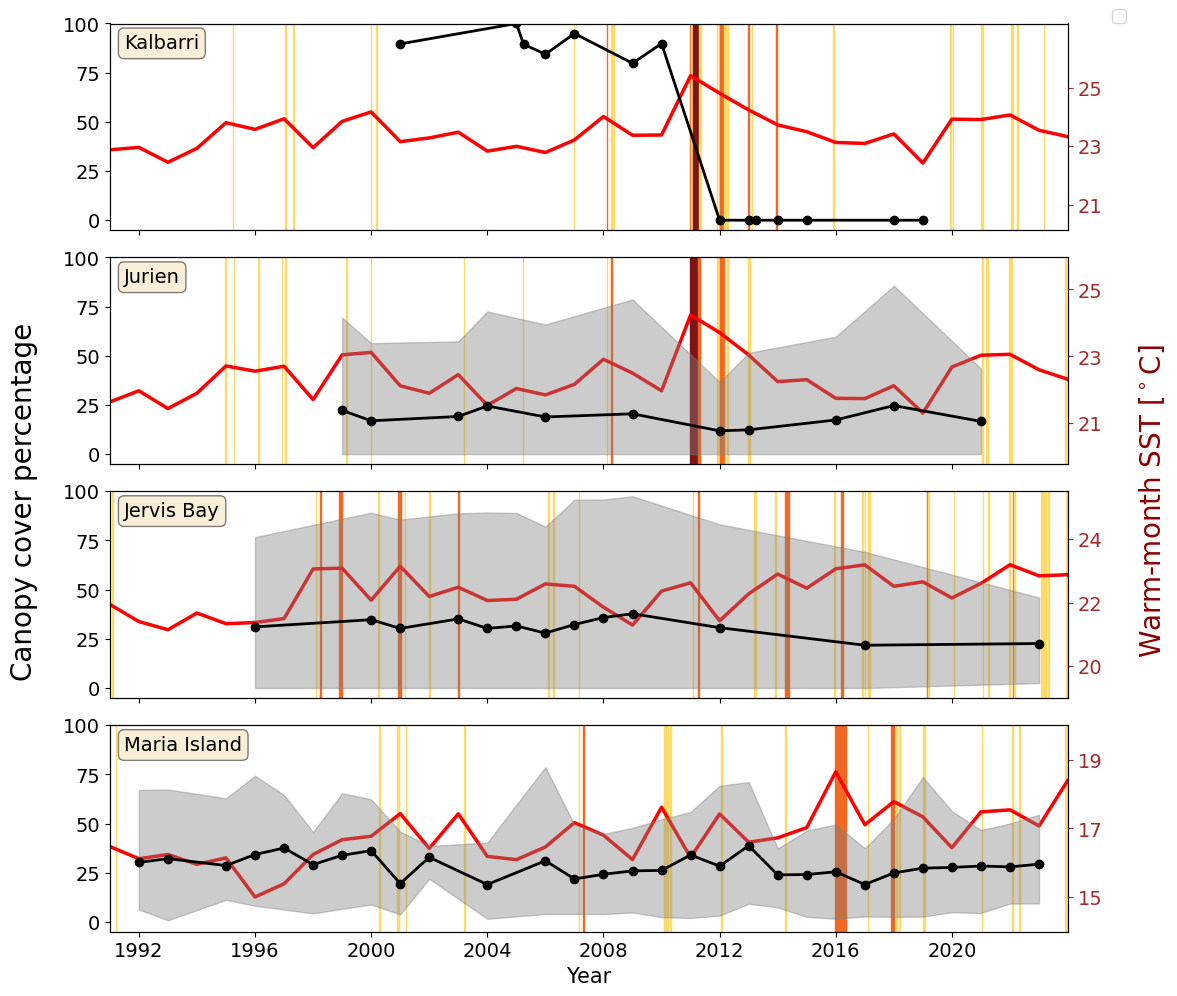

In [13]:
# start plotting, each subplot represents each location
fig, axs = plt.subplots(4, 1, figsize=(12, 10), sharex=True)  # Adjust the figsize as needed,   not sharey=True

# Loop through each unique index and plot the data
for idx, loca in enumerate(df_name.location.unique()):
    # Use the current axis !!
    ax = axs[idx]    
    ax2 = ax.twinx()  
    
    dfi = df_site_kelp[df_site_kelp.location == loca]
    input_lat = df_site_kelp.latitude[df_site_kelp.location == loca].mean()
    input_lon = df_site_kelp.longitude[df_site_kelp.location == loca].mean()
    
    dfi = dfi.sort_values(by=['site_name', 'survey_year'])
    
    if loca == 'Kalbarri':
        dfi['survey_datetime'] = pd.to_datetime(dfi['survey_year'].astype(str) + '-01-01')
        # Count repeated years (0 for first, 1 for second, 2 for third, ...)
        dfi['dup_count'] = dfi.groupby('survey_year').cumcount()
        # Shift later duplicates by +3 months each using DateOffset
        dfi['survey_datetime'] = dfi['survey_datetime'] + dfi['dup_count'].apply(lambda x: pd.DateOffset(months=3*x))
        # print(dfi)
        ax2.plot(dfi['survey_datetime'], dfi['survey_mean'], 'o-', linewidth=2, color='k')
    
    else:  ## get a location level average and the error bar spread
        # Convert to datetime format
        dfi['survey_datetime'] = pd.to_datetime(dfi['survey_year'].astype(str) + '-01-01')
        dfi_grouped = dfi.groupby(['survey_datetime'])['survey_mean'].agg(annual_mean='mean', annual_min='min', annual_max='max').reset_index()

        # Plot with shadings representing the min and max spread of site-level data
        dfi_grouped['error_lower'] = dfi_grouped['annual_mean'] - dfi_grouped['annual_min']
        dfi_grouped['error_upper'] = dfi_grouped['annual_max'] - dfi_grouped['annual_mean']
        ax2.fill_between(dfi_grouped['survey_datetime'], dfi_grouped['annual_min'], dfi_grouped['annual_max'], color='gray', alpha=0.4)
        ax2.plot(dfi_grouped['survey_datetime'], dfi_grouped['annual_mean'], 'o-', linewidth=2, color='k')
    
    ##=================== sst =============================
    infile = 'OBIS_kelp_sst.nc'  
    ds = xr.open_dataset(infile).sel(
        time = slice('1991-01-01','2024-12-31')).sel(
        lat = slice(input_lat-0.25, input_lat+0.25), lon = slice(input_lon-0.25, input_lon+0.25)).squeeze('zlev', drop=True).mean(dim=("lat", "lon"))
    # only summer temp mean
    ds_summer = ds.sel(time=ds.sst.time.dt.month.isin([12,1,2,3,4]))
    date = np.array(ds_summer.time,dtype='datetime64[ns]')
    df = pd.DataFrame(date, columns=['date']) 
    df['temp'] = pd.DataFrame(ds_summer.sst.values)
    df = df[['temp']].set_index(df.date)
    df_summer = df.resample('AS-DEC').mean()
    # add one year, to match the year of Jan
    df_summer['survey_year'] = pd.to_datetime((df_summer.index.year + 1).astype(str) + '-01-01')
    
    ## mhw vertical fill
    t = ds.time.values
    sst = ds.sst.values
    clim = threshold(ds.sst, climatologyPeriod=[1991, 2020])
    mhw = detect(ds.sst, clim.thresh, clim.seas)
    n_events = len(mhw.events)
    
    # Plot SST
    ax.plot(df_summer.survey_year, df_summer.temp, '-', color = 'red', linewidth=2.5)
    for i in range(n_events):
        if mhw['time_peak'][i].dt.month.isin([12,1,2,3,4]):
            t1 = np.where(t==mhw['time_start'][i].values)[0][0]
            t2 = np.where(t==mhw['time_end'][i].values)[0][0]
            if mhw['category'][i] == 1:
                ax.fill_between(t[t1:t2+1], min(sst), max(sst), color=col_cat1)
            if mhw['category'][i] == 2:
                ax.fill_between(t[t1:t2+1], min(sst), max(sst), color=col_cat2)
            if mhw['category'][i] == 3:
                ax.fill_between(t[t1:t2+1], min(sst), max(sst), color=col_cat3)
            if mhw['category'][i] == 4:
                ax.fill_between(t[t1:t2+1], min(sst), max(sst), color=col_cat4)
    
     # Add a text box
    textstr = str(loca)
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    ax.text(0.015, 0.95, textstr, transform=ax.transAxes, fontsize=14, verticalalignment='top', bbox=props)
    
    if loca == 'Maria Island':
        ax.set_ylim(14, 20)
        ax.set_yticks([15, 17, 19])
    elif loca == 'Jervis Bay':
        ax.set_ylim(19, 25.5)
    else:
        ax.set_ylim(sst.min()+2, sst.max()-2.5)
        ax.set_yticks([21, 23, 25])
    
    ax.set_xlim(t[0], np.datetime64('2023-12-31T12:00:00.000000000'))
    # ax.set_xticks(np.arange(1992, 2024, 4))
    ax2.set_ylim(-5, 100)
    ax.yaxis.set_label_position("right")
    ax.yaxis.tick_right() 
    ax.tick_params(axis='y', labelsize=14, colors = 'brown')   ## pay attention to 'colors'
    ax2.yaxis.set_label_position("left")
    ax2.yaxis.tick_left() 
    ax.tick_params(axis='x', labelsize=14)
    ax2.tick_params(axis='y', labelsize=14)

# Set the xlabel only for the last subplot
axs[-1].set_xlabel('Year', fontsize=15)
fig.text(0.92, 0.5, r'Warm-month SST [$^\circ$C]', ha='center', va='center', rotation='vertical', fontsize = 20, color = 'darkred')
fig.text(-0.02, 0.5, 'Canopy cover percentage', ha='center', va='center', rotation='vertical', fontsize = 20)

# Create a shared legend outside the subplots
handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, fontsize='large', loc='upper left', bbox_to_anchor=(0.88, 1))    ## bbox_to_anchor is used to adjust the distance between legend and main figure

# Adjust the layout to make space for the legend
fig.tight_layout()
fig.subplots_adjust(right=0.85) 

plt.show()